# Lab Solutions

## DSCI 561 Lab 3 - Question 2

*Usual lab instructions on submitting are here.*

## Grading Scheme (NEW!)

Many of you are familiar with the "Traditional Grading" model that is in place in most courses.
Briefly, this model involves earning (or losing) points on individual assessments throughout the course, and then a grade calculated by doing a "weighted-average" throughout the term.

You may be surprised to learn that this is not the only way classes can be structured, and there are alternative models that research has shown to be far better for learning, motivation, attitudes, and long-term benefit.
If you're interested in learning more details about the last sentence (and if it surprises you), I encourage you to [check out this very accessible paper](https://www.lifescied.org/doi/full/10.1187/cbe.cbe-14-03-0054) from Schinske and Tanner.

I am not quite ready to fully move away from Traditional Grading yet (mostly because of a lack of resources, otherwise I'm totally all-in!) but I'd like to experiment with a modified version of Specifications-Grading here in this course.
I'd love to hear your feedback on it!
Here are some [key features](https://twitter.com/siwelwerd/status/1472940473924960261) of Specifications Grading:

- Each assignment is accompanied with a clear list of "specifications" of what constitutes acceptable work at each level.
- Assignments are marked based on whether students have met each of the specifications for that assignment.
- Students are given multiple opportunities to revise their work to demonstrate their learning.

In this course, the image below shows a handy guide to help you understand this grading system: 

<img src="images/specifications_rubric.png" width="100%">

I prefer **not** to associate percentages or grades to the levels (I personally feel that this hampers your learning and poisons motivation and creativity), but I know that it will take us some time to eliminate grades completely.
If you must think of things in terms of numbers and percentages, you can expand the box below to see my best guess of what each level translates into.

Resist the temptation to click this button!

- The **E**, or "Excellent" level is about 100%.
- The **G**, or "Good" level is about 85%.
- The **R**, or "Revision Required"  level is < 50%.
- The **I** or "Incomplete" level is not associated with a number because it was not graded.

### Resubmission Policy

This term, you will be able to resubmit your work up to a maximum of 2 times after you have receive feedback.
Each time you do a resubmission, you will first need to reflect on your initial submission, and discuss how you corrected your work after receiving feedback from the TAs.

Your resubmission request can be submitted on Gradescoope but we reserve the right to decline your resubmission if the quality and depth of your reflection is not up to our specifications.


## Pre-requisite Knowledge

Before doing this lab, students should:

- be comfortable performing Exploratory Data Analysis (EDA).
- be able to perform the mechanics of performing linear regressions in R using the `tidyverse`.
- be able to identify collinearity and multi-collinearity in variables using a variety of methods (correlation matrix, correlogram, visualizations, variance inflation factor, etc...).

## Learning Intentions

- Implement a simple linear regression, and a multiple linear regression in the R programming language.

- Develop some *intuition* about the correlation ($R$), and assess whether there is collinearity between two variables.

- Use the Variable Inflation Factor (VIF) to determine whether multicollinearity exists in a regression analysis.

- Critically examine strategies for resolving multicollinearity in regression analyses (**focus of this lab**).

In [1]:
# Load libraries

# Adjust plot aspect ratio and apperance
library(repr)
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 400)

library("tidyverse")
library("moderndive")

suppressPackageStartupMessages({
  library("janitor")
  library("car")
  library("corrplot")
  library("ISLR")
  library("plotly")
  library("cowplot")
})

# Only display 10 rows of tibble
repr_html.tbl_df <- function(obj, ..., rows = 10) repr:::repr_html.data.frame(obj, ..., rows = rows)

# fit summary
fit_summary <- function(model) {
  tb <- broom::glance(model)
  tb <- tb |>
    add_column(r = sqrt(tb$r.squared), .before = "r.squared") |>
    rename(`R^2` = r.squared, R = r)
  return(round(tb, 3))
}
# Overwrite

regression_table <- function(model) {
  tbl <- get_regression_table(model) |> rename(beta = estimate)
  tbl <- tbl |> add_column(std_error_perc = abs(round(100 * tbl$std_error / tbl$beta, 2)))
  return(tbl)
}

## 2.0 - Introduction

In this question, you will continue your analysis of the `boston` dataset.
In question 1 of this lab, you have already done some exploratory data analysis of the `boston` dataset, but we are repeating the same introductory information here for completeness.

### Housing Values in Suburbs of Boston

This is an old dataset about house values in the suburbs of Boston in the year 1978.
It contains 14 columns, and 506 rows and each row indicates a different "town" in Boston.
`MEDV` is the median value of owner-occupied homes and is generally considered to be the response variable.

The columns and their descriptions are provided below:

| Original Column | Suggested Column Name | Description |
| ------ | ------- | ----------- |
|CRIM | crime | per capita crime rate by town|
|ZN | res | proportion of residential land zoned for lots over 25,000 sq.ft.|
|INDUS | industry | proportion of non-retail business acres per town|
|CHAS | river | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|NOX | nox | nitric oxides concentration (parts per 10 million)|
|RM | rooms | average number of rooms per dwelling|
|AGE | age | proportion of owner-occupied units built prior to 1940|
|DIS | emp | weighted distances to five Boston employment centres|
|RAD | highway | index of accessibility to radial highways|
|TAX | tax | full-value property-tax rate per \$10,000|
|PTRATIO | teaching | pupil-teacher ratio by town|
|B | black | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town|
|LSTAT | lower | Proportion of population that is lower status = 1/2 (proportion of adults without, some high school education and proportion of male workers classified as laborers). The logarithmic specification implies that socioeconomic status distinctions mean more in the upper brackets of society than in the lower classes |
|MEDV | price | Median value of owner-occupied homes. Data censored with a max of 50 (meaning $50,000) |

**N.B. I am intentionally giving you a flawed dataset for this lab so that you can carefully and critically consider some of the ethical questions that arise while working with this, and other data. If you feel that doing this lab would cause you harm (for instance, as a result of reliving personal trauma), please let me know and I'll provide you an alternative dataset.**

## 2.1 - Load the dataset

**Specifications**

- Load the dataset and bind it to a variable called `boston`.

In [2]:
# Your code here

boston <- read_csv("https://raw.githubusercontent.com/org-firasm/ubc_stats/main/class/week01/boston.csv", col_types = cols())

boston

crime,res,industry,river,nox,rooms,age,emp,highway,tax,teaching,black,lower,price
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24000
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21600
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34700
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33400
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36200
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.06263,0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21,391.99,9.67,22400
0.04527,0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21,396.90,9.08,20600
0.06076,0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21,396.90,5.64,23900


### [Sample Answer]

> See above.

#### [Grading notes]

- An **E** is an answer with the data collectly loaded.
    
- A **G** answer is not possible here.

- An **R** answer is not possible here.

- An **I** answer is incomplete, and not gradeable.

## 2.1 - Correllogram

**Specifications**

- Create a correllogram using the [`corrplot` package](https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html) of all the numeric variables in the `boston` dataset.
- You may use the `cor()` or a simialr function, but you should NOT calculate the correlations manually.
- Round your correlations to 2 significant figures.
- Ensure that you explore some of the options [available in the documentation](https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html) to customize your correllogram for this dataset.
- Ensure that there is no repeated or duplicated information in your correllogram (i.e. choose upper or lower triangle)

In [34]:
# Your code here

### [Sample Answer]

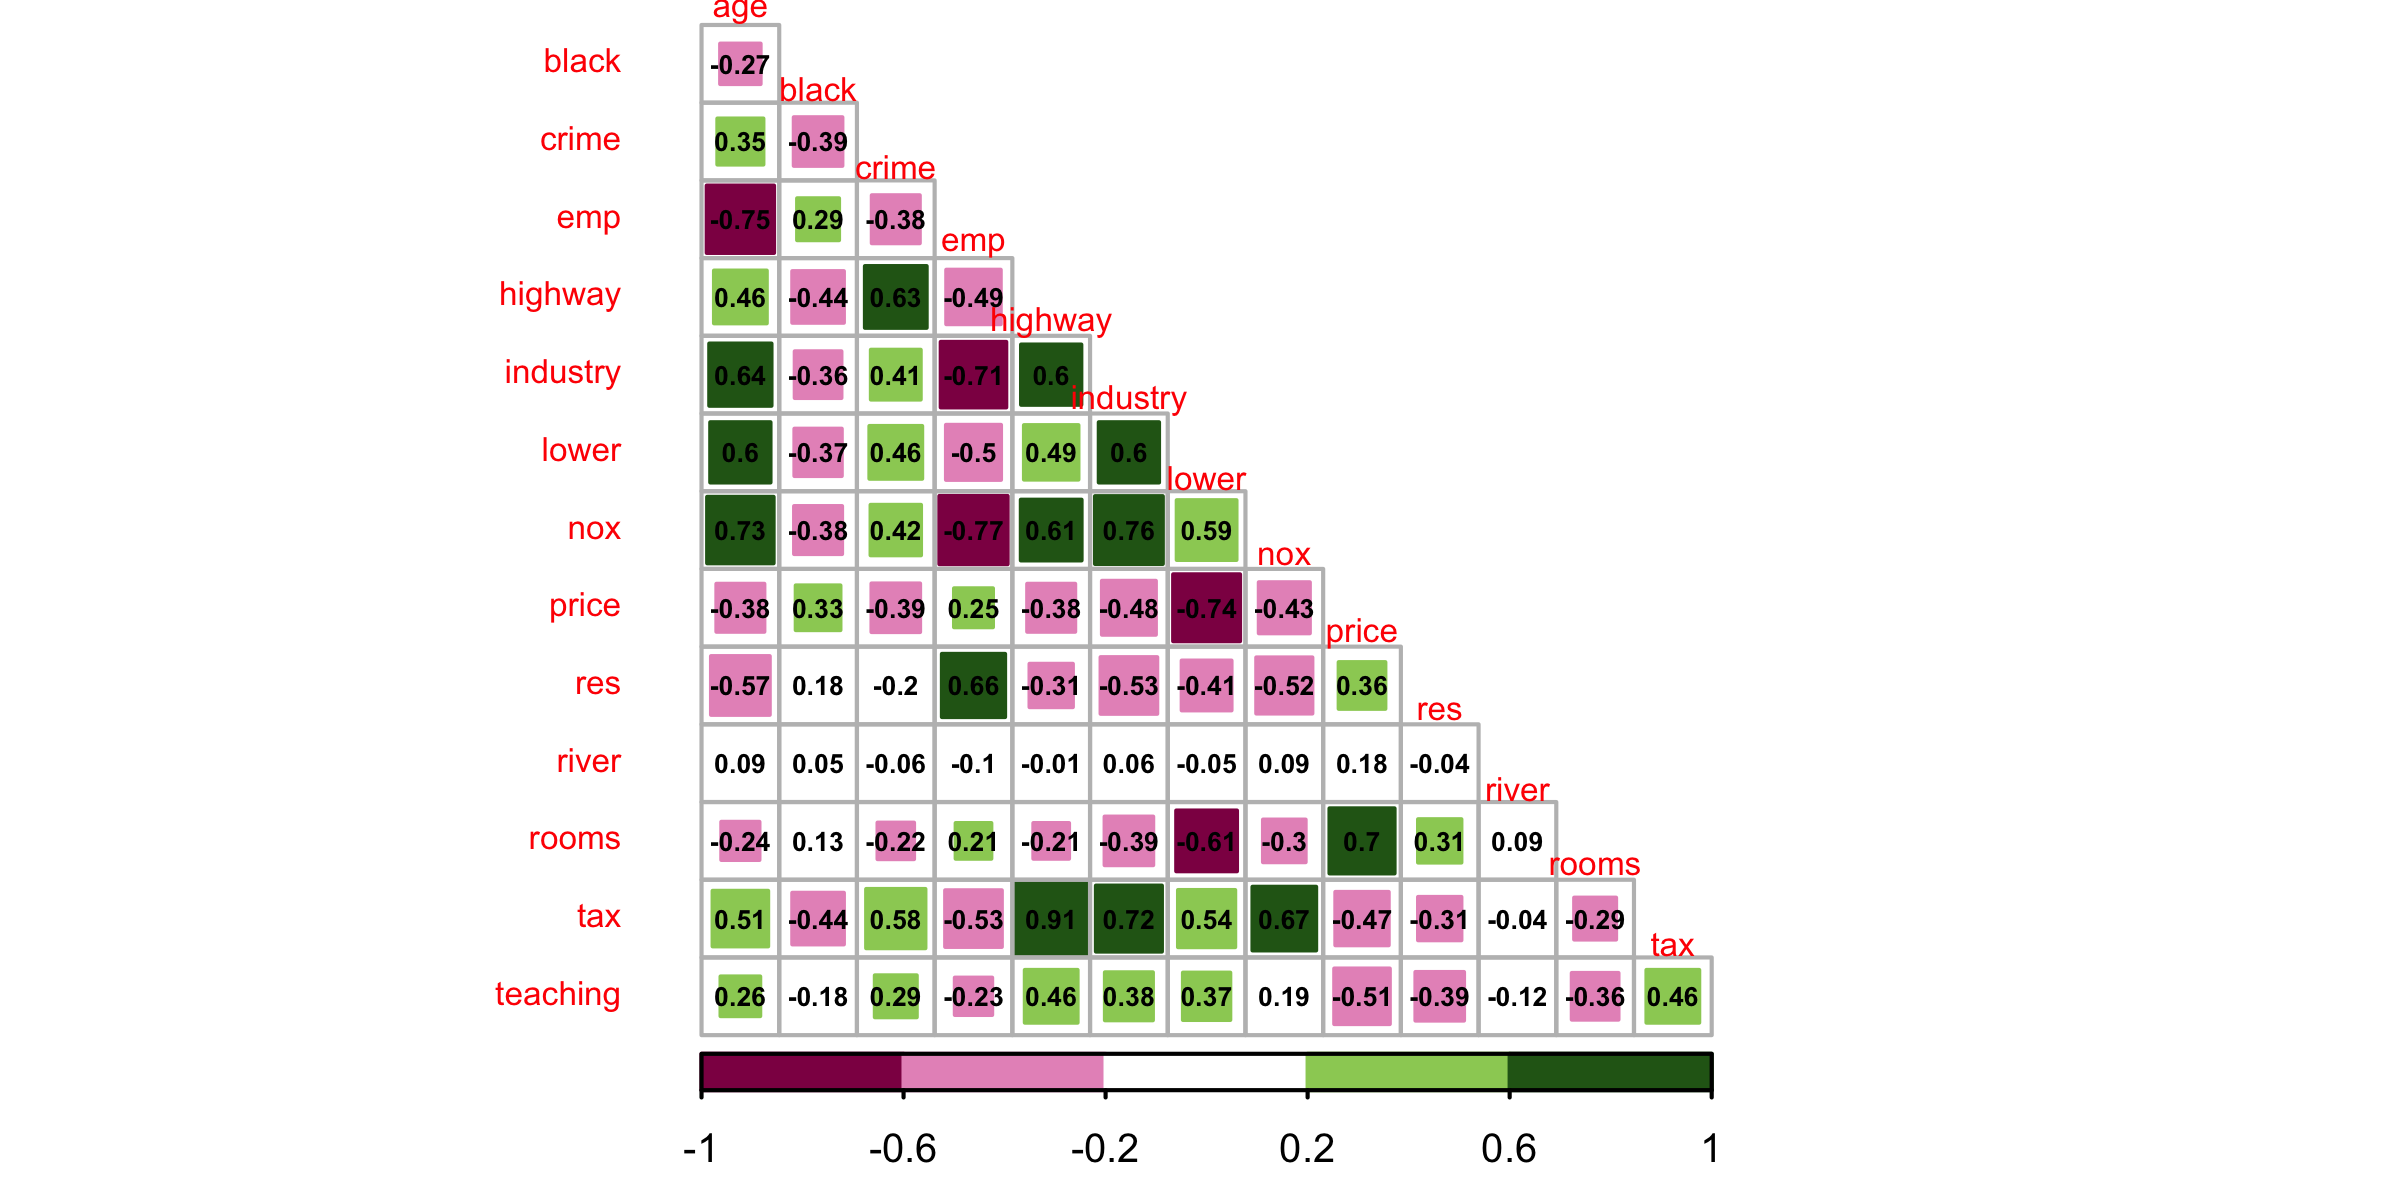

In [35]:
res <- round(cor(boston |> select(where(is.numeric))), 2)

corrplot(res,
  method = "square", type = "lower", diag = FALSE,
  addCoef.col = "black", number.cex = 0.4, cl.cex = 0.6, tl.cex = 0.5, tl.pos = "ld", tl.offset = 1,
  order = "alphabet", tl.srt = 0, col = COL2("PiYG", 5)
)

#### [Grading notes]

- An **E** is a reasonable correlation plot (any variety) where the values can be read off the table, and care has been taken to ensure the image follows principles of effective visualizations.
    
- A **G** answer is one where a correlation plot was created, but it is not effective (provide feedback or reference the principles if it's not the case).

- An **R** answer is one where a correlation plot was created, but it is incorrect, or inappropriate, or unreadable. Provide feedback on what the student could do to improve.

- An **I** answer is incomplete, and not gradeable.

## 2.2 - Identifying Explanatory Variables

**Specifications**

- From the 13 available explanatory variables, select 6 that you would like to use for your multiple linear regression.
    - Remember, the **research question** is to predict the price response variable is `price` based on the explanatory variables.
- Provide a one-sentence rationale for why you chose each of the 6 variables for your analysis.


> Your answer here (select 6 variables and provide a rationale for why)

### [Sample Answer] 

#### Explanatory Variable that could be selected

| Explanatory Variable | Justification                                                         |
|----------------------|-----------------------------------------------------------------------|
| crime                | High crime rate is very likely to significantly decrease house value.|
| highway              | Increased accessibility to highways is likely a positive factor in determining house value, but being too close may result in lower prices due to noise, congestion, safety.                             |
| tax                  | This variable is probably extremely correlated to the housing price (since the tax rate is linked to house value)                           |
| black                | Recognizing that this dataset is from 1978, including the proportion of black residents in the neighbourhood is probably important in perpetuating prejudice (or, predict house value based on problematic data).        |
| nox                  | Higher nitrix oxide concentration in the air (pollution) should result in lower housing values.|
| rooms                | Larger homes will have more bedrooms, and thus, should be values higher. |
| teaching       | Lower teaching ratios would indicate wealthier neighbourhoods and higher quality schools.                                        |
| industry             | The higher the proportion of non-retail businesses in a town, the lower the house should be valued. |
| lower                | Another problematic demographic variable, but one that is likely to reflect prejudices in neighbourhood quality/value.                  |
| age                  | This is a complicated variable; old houses may be larger and worth more in more prestigious neighbourhood, but may need more renovations. Not sure which way this would go, but worth including to understand/explain. |
| emp                  | Poorer neighbourhoods will need to have employment centers closer by, but also be nearer to urban centers.                   |



#### Explanatory Variable that should *not* be selected

| Explanatory Variable | Justification                                                         |
|----------------------|-----------------------------------------------------------------------|
| price                | This is the response variable.                             |
| river                | It's unlikely many properties are bordering a river, so this is probably not a good choice if we could only pick 6 explanatory variables.  |
| res                  | This just determines how much of the town is residential, and is likely related to the size of the town. Other variables are probably more important. |

#### [Grading notes]

- An **E** is an answer with all correlations in the acceptable choices (see tables above), with a good justifications for **all** pairs.
    
- A **G** answer is one where one variable is not acceptable, or if one or two of the justifications are inappropriate, invalid, illogical, or incomplete.

- An example of an **R** answer is where six variables are not clearly defined, and if three or more of the justifications are inappropriate, invalid, illogical, or incomplete.

- An **I** answer is incomplete, and not gradeable.

## 2.3 - Predicting Collinearity

**Specifications**

- Based on the correllogram you created in Question 2.1, list all **pairs of variables** that you predict are most likely to exhibit collinearity.

In [36]:
# Your code here (if necessary)

### [Sample Answer] 

In [37]:
# Credit for answer to StackOverflow user from [Peurke](https://stackoverflow.com/a/59898426/2217577)

res |>
  as.table() |>
  as.data.frame() |>
  subset(Var1 != Var2 & abs(Freq) > 0.7) |>
  filter(!duplicated(paste0(pmax(as.character(Var1), as.character(Var2)), pmin(as.character(Var1), as.character(Var2))))) |>
  arrange(desc(Freq)) |>
  rename(R = Freq)

Var1,Var2,R
<fct>,<fct>,<dbl>
tax,highway,0.91
nox,industry,0.76
age,nox,0.73
tax,industry,0.72
emp,industry,-0.71
price,lower,-0.74
emp,age,-0.75
emp,nox,-0.77


**The variable pairs above will likely exhibit high degree of collinearity based on the $|R| > 0.7$.**


#### [Grading notes]

- An **E** is an answer with all correlations above ~ 0.7 listed, negative or positive and have provided a brief 1-sentence explanation for the rationale.
    - Though, if students list all correlations over 0.6, you can award them an **E**, but with feedback that the threshold should be slightly higher.
    
- A **G** answer is one that has negative correlations missing (provide feedback), or if they've missed any of the pairs.

- An example of an **R** answer is where only a threshold is given, but the variables aren't listed. Provide feedback that the specifications required a listing of the variable.

- An **I** answer is incomplete, and not gradeable.

## 2.4 - Multiple Linear Regression


**Specifications**

- Run a Multiple Linear Regression on the 6 explanatory variables you selected in Q2.2 and use the `price` variable as the response variable.
- Save the model as `model1`, and produce two tibbles: one with the `regression_table()` and the other with the `fit_summary()`, similar to what was done in Class 5 and 6.

In [38]:
# Your code here

### [Sample Answer]

In [39]:
model1 <- lm(price ~ crime + highway + tax + nox + rooms + black, boston)

In [40]:
regression_table(model1)

term,beta,std_error,statistic,p_value,lower_ci,upper_ci,std_error_perc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-22865.887,3695.006,-6.188,0.000,-30125.574,-15606.200,16.16
crime,-134.908,39.797,-3.390,0.001,-213.097,-56.718,29.50
highway,186.067,77.074,2.414,0.016,34.637,337.497,41.42
tax,-15.204,4.075,-3.731,0.000,-23.210,-7.197,26.80
nox,-5206.039,3103.373,-1.678,0.094,-11303.327,891.248,59.61
rooms,7664.391,401.146,19.106,0.000,6876.249,8452.534,5.23
black,14.119,3.285,4.299,0.000,7.666,20.573,23.27


In [41]:
fit_summary(model1)

R,R^2,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.771,0.594,0.589,5893.739,121.789,0,6,-5107.371,10230.74,10264.56,17333345191,499,506


#### [Grading notes]

- An **E** answer performs the multiple linear regression on the 6 explanatory variables, and reports the regression table and the fit summary with all of the relevant information.
    
- A **G** answer performs the multiple linear regression, but does not report either the regression table, or the fit summary.

- An **R** answer will perform an incorrect linear regression or, does not report the regression table and the fit summary.

- An **I** answer is incomplete, and not gradeable.

## 2.5 - Detecting multicollinearity

**Specifications**

- Using the method described in Class 5, manually calculate VIF values for all of your explanatory variables in the regression you did in Q2.4.
- Use the `vif()` function in the `car` package to confirm that your calculations are correct.
- Provide a few sentences of commentary explaining whether there is multi-collinearity present in your regression.

In [42]:
# Your code here

> Your answer here.

### Sample Answer

Here is a sample table of VIF values for this particular regression (of course, other answers are possible depending on the variables chosen).

There is likely two variables that have a VIF > 5 and demonstrate extreme multicollinearity. It is also possible that students chose a combination of variables that demonstrate mild multicollinearity (VIF between 2 and 5), or very little multicollinearity (VIF between 1 and 2). This is fine, evaluate each answer based on the student's actual VIF values.

In [43]:
round(car::vif(model1), 2)

crime highway     tax     nox   rooms   black 
   1.70    6.55    6.86    1.88    1.15    1.31

| Variable | VIF     |
| -------- | ------- |
| crime | 1.7|
| highway | 6.6|
| tax | 6.9 |
| nox | 1.9 |
| rooms | 1.2 |
| black | 1.3 |

#### [Grading notes]

- An **E** is an answer with the VIF values calculated correctly, matching those from the `car::vif()` function, with an excellent answer explaining and interpreting their VIF table.
    
- A **G** answer is one where the VIF values are not checked against the `car::vif()` function, and/or with an passable answer explaining and interpreting their VIF table.

- An **R** answer is where the VIF values are not calculated correctly, or an incorrect explanation/interpretation of their VIF table was provided.

- An **I** answer is incomplete, and not gradeable.

## 2.6 - Addressing multicollinearity

At the end of Class 5, you were provided three different strategies to deal with multicollinearity in Linear Regression analyses.
In this question, you will use the `boston` dataset to explore some options to address multicollinearity.

For this question, if the linear regression you did in Q2.4 and Q2.5 contains at least two variables with a VIF > 5, you may use the same same regression for this question.

If the linear regression you did in Q2.4 and Q2.5 did NOT contain any variables with VIF > 5, do another regression such that you have at least two (and no more than four) variables that have VIF > 5.

### 2.6.1 - Ignore multicollinearity

**Specifications**

- Interpret the regression analysis ($\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc...) and comment on its suitability for prediction and for inference (separately).
- Would you bet on your model to help you guide your home buying decisions? Why or Why not?

In [44]:
# Your code here (if necessary)

> Your answer here

### Sample Answer

Answers here will vary depending on the variables chosen, and assumptions made.

#### [Grading notes]

- An **E** is an answer with an excellent interpretation of the output of their regression analysis. In particular, $\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc... An excellent answer should consider:
    - where appropriate, significance of their regression should be considered.
    - where appropriate, students should comment on higher p-values and standard errors in cases where there is collinearity (for example, if they use the `tax` and `highway` columns).
    - the implication of having 6 explanatory variables. Though we haven't covered it in class yet, considering the use of relative AIC and BIC would be notable. Even if they don't mention AIC and BIC, just the consideration of whether or not it is appropriate to use six explanatory variables in this situation would be sufficient
    - the relatively low $R$ and $R^2$ values as reasoning against betting on this model to help guide their home buying decisions.
    
- A **G** answer is one where the metrics ($\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc...) are stated, but not interpreted.

- An **R** answer is one where the metrics ($\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc...) are interpreted incorrectly or inappropriately (for e.g., vague and unclear).

- An **I** answer is incomplete, and not gradeable.

### 2.6.2 - Drop a collinear variable to resolve multicollinearity

**Specifications**

- Perform another multiple linear regression on the `boston` dataset **after** resolving multicollinearity by dropping one or two variables from your regression analysis.
- Compute VIF values for your new analysis and comment on the change (you may use the `car` package from now on).
- Carefully consider your threshold for dropping a variable and justify it.
- Compare your analysis to your previous one with multicollinearity.
- Comment on the suitability of this solution.

In [45]:
# Your code here

> Your answer here

### Sample Answer

In [46]:
model1b <- lm(price ~ crime + tax + nox + rooms + black, boston)

In [47]:
regression_table(model1b)

term,beta,std_error,statistic,p_value,lower_ci,upper_ci,std_error_perc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-25322.357,3569.247,-7.095,0.000,-32334.927,-18309.787,14.10
crime,-107.940,38.381,-2.812,0.005,-183.347,-32.533,35.56
tax,-7.228,2.397,-3.015,0.003,-11.938,-2.518,33.16
nox,-5108.821,3118.057,-1.638,0.102,-11234.930,1017.288,61.03
rooms,7825.029,397.494,19.686,0.000,7044.066,8605.993,5.08
black,13.605,3.293,4.131,0.000,7.134,20.075,24.20


In [48]:
fit_summary(model1b)

R,R^2,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.768,0.589,0.585,5922.126,143.595,0,5,-5110.309,10234.62,10264.2,17535788148,500,506


In [49]:
round(car::vif(model1b), 1)

crime   tax   nox rooms black 
  1.6   2.4   1.9   1.1   1.3

#### [Grading notes]

- An **E** is an answer with an excellent interpretation of the output of their regression analysis. In particular, $\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc... An excellent answer should include:
    - everything in 2.6.1 *as well as* a comparison of what changed when the collinear variable was dropped, as well as an interpretation of what it *means*.
    - a note of surprise if the standard errors increased, and potential explanations as that may be counter-intuitive (these do not have to correct, but provide feedback if they are wrong).
    - computing new VIF values as well as a commentary on the change (i.e. did it solve the multicollinearity problem)?
    
- A **G** answer is one where the metrics ($\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc...) are stated, but not interpreted, or compared.

- An **R** answer is one where the metrics ($\beta$, standard error, p-value, test statistic, $R$, $R^2$, etc...) are interpreted incorrectly or inappropriately (for e.g., vague and unclear).

- An **I** answer is incomplete, and not gradeable.

### 2.6.3 - Transform collinear variables to resolve multicollinearity

**Specifications**

- Perform another multiple linear regression on the `boston` dataset **after** resolving multicollinearity by creating a new composite variable from a weighted combination of other collinear variables.
- Carefully consider your choices for the weighted average, and justify them.
- Compare your analysis to the original regression with multicollinearity.
- Comment on the suitability of this solution.

In [50]:
# Your code here

> Your answer here

### Sample Answer

In [51]:
# let's combine `tax` and `highway` together to try and remove collinearity

boston_transform <- boston |> add_column(highway_tax = 0.4 * boston$highway + 0.6 * boston$tax)

model1c <- lm(price ~ crime + highway_tax + nox + rooms + black, boston_transform)

In [52]:
regression_table(model1c)

term,beta,std_error,statistic,p_value,lower_ci,upper_ci,std_error_perc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-25406.673,3567.602,-7.121,0.000,-32416.012,-18397.334,14.04
crime,-108.020,38.480,-2.807,0.005,-183.623,-32.418,35.62
highway_tax,-11.520,3.885,-2.966,0.003,-19.153,-3.888,33.72
nox,-5185.945,3119.219,-1.663,0.097,-11314.337,942.447,60.15
rooms,7830.843,397.486,19.701,0.000,7049.895,8611.791,5.08
black,13.621,3.295,4.134,0.000,7.147,20.095,24.19


In [53]:
fit_summary(model1c)

R,R^2,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.768,0.589,0.585,5923.854,143.453,0,5,-5110.457,10234.91,10264.5,17546025397,500,506


In [24]:
round(car::vif(model1c), 1)

crime highway_tax         nox       rooms       black 
        1.6         2.4         1.9         1.1         1.3

#### [Grading notes]

- An **E** is an answer with the transformation of two collinear variables is done correctly, new VIF values are calculated correctly, and there is excellent commentary on the suitability of the situation, as well as a comment that in this case, it likely does not matter if the variables are transformed or one just removed to resolve the multicollinearity.
    
- A **G** answer is one where the transformation was done, but there is insufficient commentary around the process and interpretation *of what it all means*.

- An **R** answer is one where where the transformation is not done correctly, or if the VIF values are not calculated correctly, or if there is an incorrect explanation/interpretation provided for this solution.

- An **I** answer is incomplete, and not gradeable.

### 2.7 - Reflection Questions

**Specifications**

- You should answer each question with about 3-5 sentences and your responses should be concise, substantial, thoughtful, and reflective.
- You should also demonstrate a thorough understanding of the concept or question.

#### 2.7.1 Comment on the ethical considerations of using some of the variables in this dataset

Hint: In particular, consider the implications of `black`, `highway`, `emp`, `crime` in a linear regression and what types of biases this may introduce in your regression analysis.

> Your answer here

### [Sample Answer]

> - In this lab, at various points we have conflated the danger of collinearity, with issues of ethics without diving into too many of the details.
    - These details will be covered during the lab session - for instance, many of the variables may be intrinsically linked to established social norms, but may not show its effects *yet*.
> - Many of these variables described here have decades of socioeconomic inequity (all variables), racism (`black`, `crime`, `teaching`), sexism (`lower`) built into them. To make predictions with this data (even at that time) would be unethical and immoral.
> - Doing inference-type problems may be more justifiable, particularly if the goal is to understand the impact and effect of various policies on reversing these inequities, or to understand the amount of harm that was done.


#### [Grading Notes]

- An **E** answer will be thoughtful, considerate, reflective, complete, and detailed. The answer should make clear references to the linked article and provide original thoughts and commentary.
    
- A **G** answer is not possible for this question because we expect everyone to put a substantial amount of consideration and effort.

- An **R** answer is one where issues from the linked article are discussed in vague and uncertian terms, but there are no clear references to the linked article.

- An **I** answer is incomplete, and not gradeable.

#### 2.7.2 Explore the `black` variable in a bit more detail, and comment on the assumptions that were made when this dataset was put together.

Hint: In particular, I suggest starting with visualizing the function `1000(Bk - 0.63)^2`. What does it mean? What does it imply? Is it right/fair/just?

In [62]:
# Your code here

> Your answer here

### [Sample Answer]

> - If the proportion of black residents in a town is 0%, the "score" is maximized at 400. 
> - If the proportion of black residents in a town is 100%, the "score" has a maximum value of 137, or 34% of the max value if the town was 100% white.
> - There is an inflexion point - if 63% of a town is black, the "score" will begin increasing to a controlled maximum. Below 63% black proportion, the "score" will increase until 400.
> - This is clearly and simply the effect of racism.

In the words of [M Carlisle](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8), a Math PhD student at NYC:

> [The `black` parameter] actually is a parameter in the model to modulate house pricing for systemic racism. When I say “systemic racism” here, I mean this mathematically. This is a term, in a statistical model to predict housing prices, that accounts for racism as a factor in pricing. If this is used to predict, or even influence future models by its very existence, then systemic racism will continue to be a pricing factor.


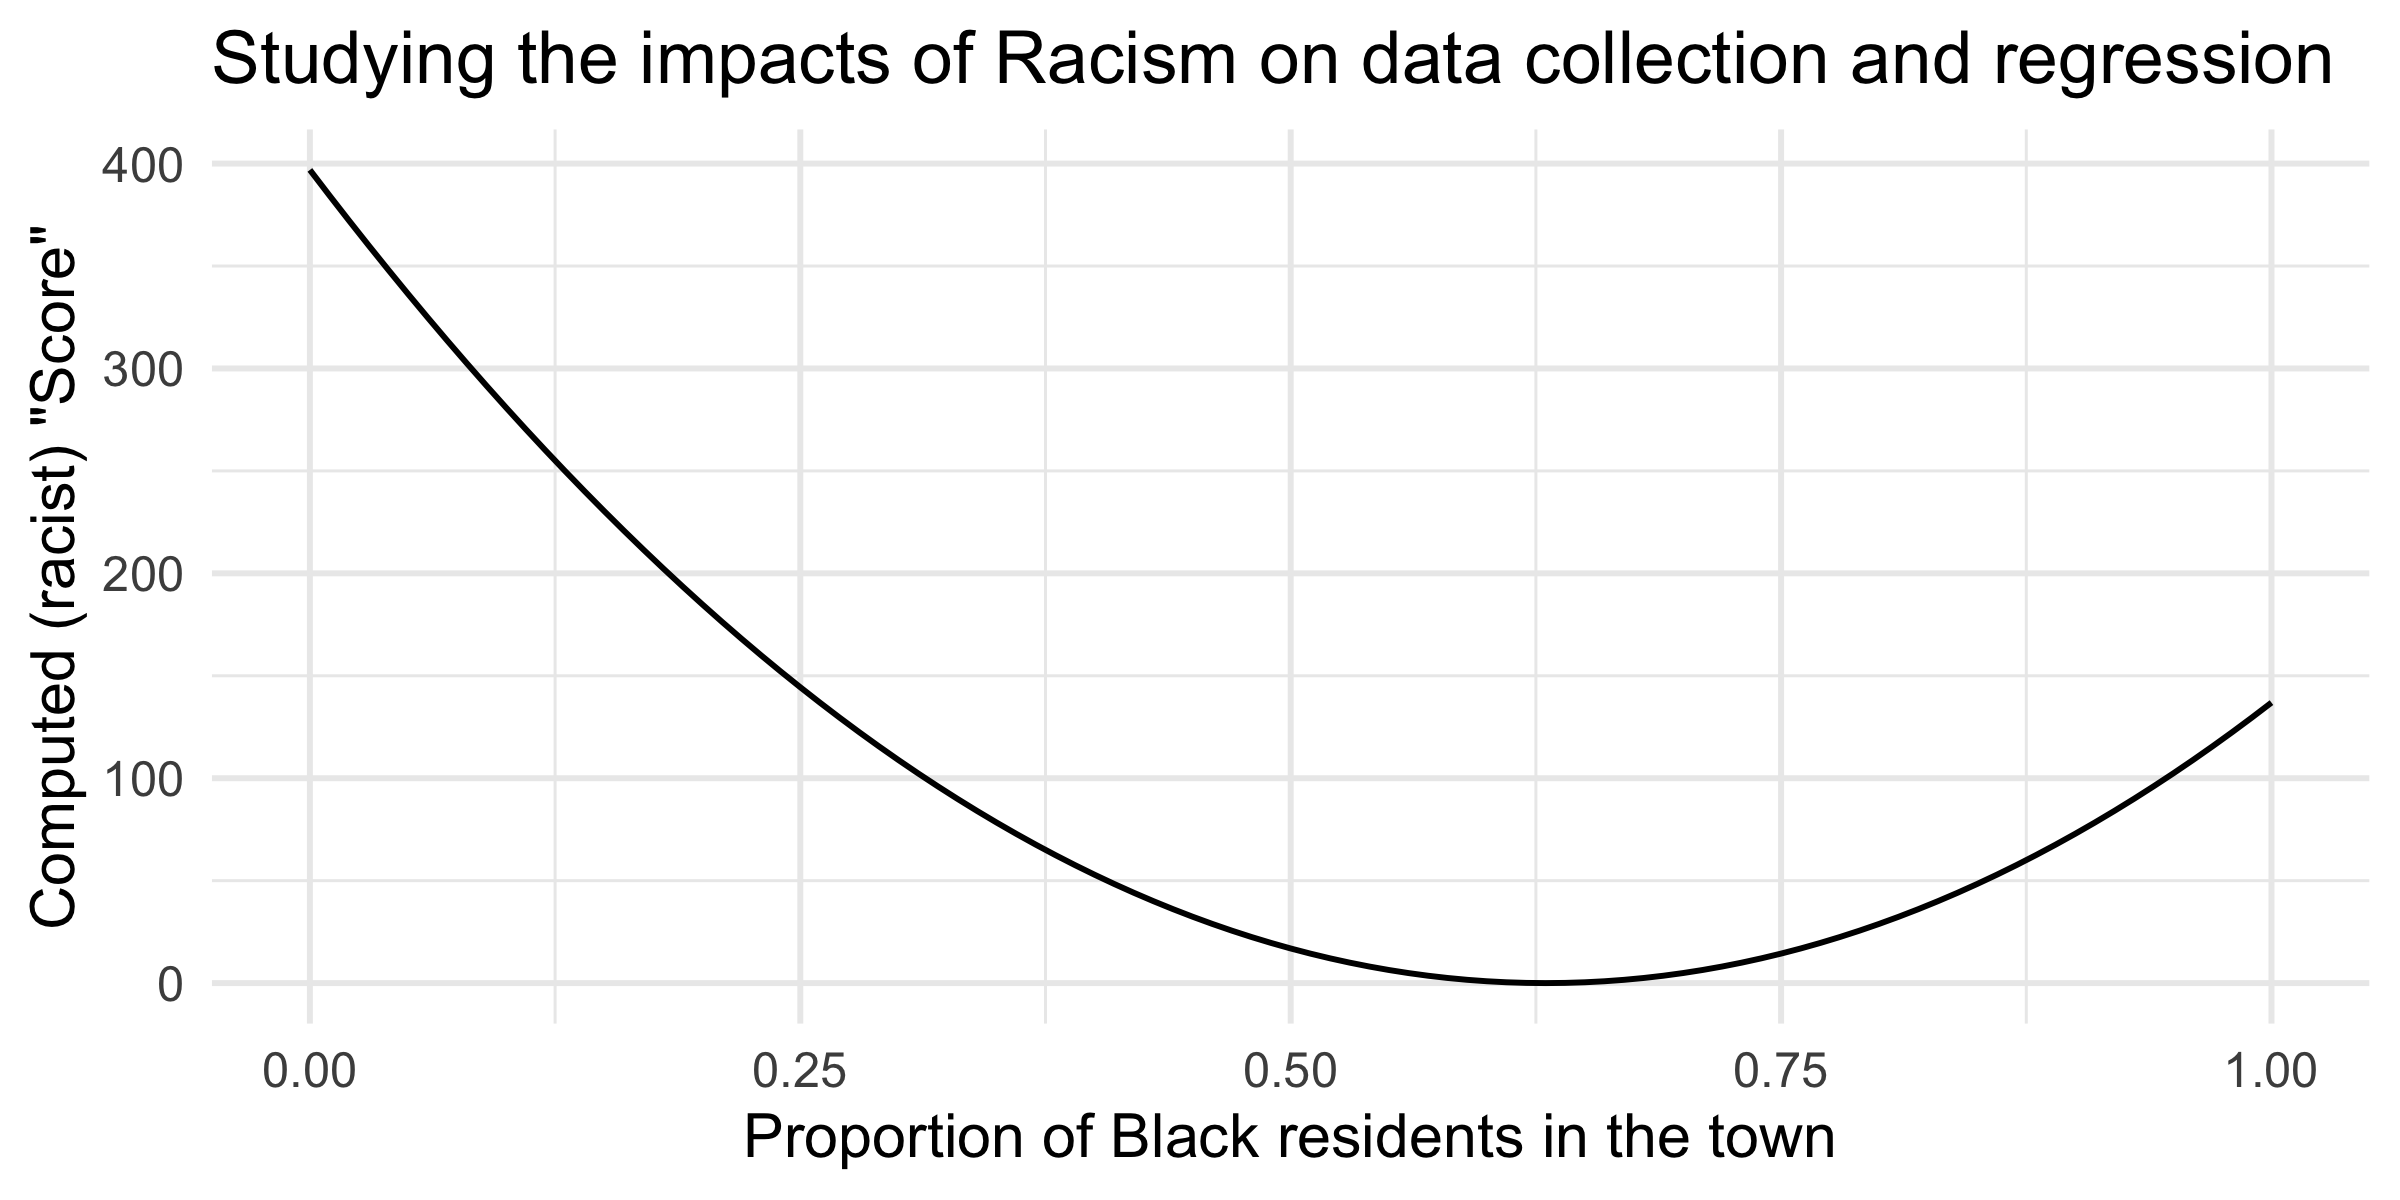

In [33]:
b_func <- function(b) {
  return(1000 * (b - 0.63)^2)
}


b_plot <-
  ggplot() +
  xlim(0, 1) +
  geom_function(fun = b_func) +
  theme_minimal() +
  labs(
    x = "Proportion of Black residents in the town",
    y = 'Computed (racist) "Score"',
    title = "Studying the impacts of Racism on data collection and regression"
  )


b_plot

#### [Grading Notes]

- An **E** answer would include a plot of the `black` variable, similar to what is shown above, and provide useful commentary on the interpretation of the curve. In particular, students should note the systemic racism prevalent in that age, and the dangers of it persisting if this data (or data similar to it) are used to make predictions.
    
- A **G** answer is one where some effort was demonstrated in trying to understand the `black` variable, but key points and conclusions were missed.

- An **R** answer is one where the student did the necessary work, but "missed the point".

- An **I** answer is incomplete, and not gradeable.

#### 2.7.3 Critically consider the advice several textbooks give about multicollinearity

Hint: The advice that is typically given is that multicollinearity is "okay" for prediction scenarios, but should be addressed when doing inference and if interpretation of the coefficients is important.

> Your answer here

### [Sample Answer]

> - Using *any* variable blindly in regression is dangerous, whether it is collinear or not, and whether it is for inference or for prediction.
> - Care must be taken to carefully consider the implication of including every variable in your analysis, and due dilligence must be a pre-requisite before diving into any analysis.
> - In particular, ignoring collinearity may be "mathematically permissible", but may have huge societal and ethical implications. 
>    - Even if there are cases where there are no ethical implications (unlikely!), I suggest you still avoiding severe multicollinearity even when doing predictions, despite conventional advice.

#### [Grading Notes]

- An **E** answer is one where care is taken to discuss the complex issues of resolving multicollinearity, both "mathematically" as well as "ethically".
    
- A **G** answer is one where either the mathematical perspective or the ethical perspective was not considered.

- An **R** answer is one where neither the mathematical perspective nor the ethical perspective was considered.

- An **I** answer is incomplete, and not gradeable.

#### 2.7.4 Read the [origins of this dataset](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8) and share your thoughts

Note: You may be tempted to adjust your answers to 2.6 after reading this article. Whether you do so or not, is your choice. Remember that this is a learning opportunity and our goal is to get you to think about some of the issues mentioned in the article *the next time* you do an analysis!

> Your answer here

### [Sample Answer]

> Many answers are possible here, there is definitely subjectivity here. Award an **E** for clear effort and consideration.

#### [Grading Notes]

- An **E** answer will be thoughtful, considerate, reflective, complete, and detailed. The answer should make clear references to the linked article and provide original thoughts and commentary.
    
- A **G** answer is not possible for this question because we expect everyone to put a substantial amount of consideration and effort.

- An **R** answer is one where issues from the linked article are discussed in vague and uncertian terms, but there are no clear references to the linked article.

- An **I** answer is incomplete, and not gradeable.